In [11]:
import numpy as np
import pandas as pd
import xarray as xr
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
from tqdm import tqdm
from datetime import datetime
import pickle 
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [12]:
# Funktion zur Vorbereitung von CSV-Daten (Konvertierung der 'dtm' Spalte in datetime-Format)
def pre_csv(df):
    df.dtm = pd.to_datetime(df.dtm)  # Konvertiert die 'dtm' Spalte in das Datumsformat
    return df

# Funktion zur Vorbereitung von DWD-Daten (Konvertierung und Bereinigung)
def pre_dwd(df):
    # Umwandeln in DataFrame, Umbenennen von Spalten und Zeitzonen-Anpassungen
    df = df.to_dataframe().reset_index().rename(columns={"ref_datetime": "reference_time", "valid_datetime": "valid_time"})
    df.reference_time = df.reference_time.dt.tz_localize("UTC")  # Lokalisierung der 'reference_time' auf UTC
    df.valid_time = df.reference_time + df.valid_time * pd.Timedelta(1, "h")  # Berechnung von 'valid_time' basierend auf Stunden
    return df

# Platzhalter für zukünftige NCEP-Datenvorbereitung (aktuell wird nichts gemacht)
def pre_ncep(df):
    return df

# Öffnen und Vorbereiten mehrerer DWD-Datensätze (PES)
df_pes_0 = pre_dwd(xr.open_dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc"))
df_pes_1 = pre_dwd(xr.open_dataset("data/dwd_icon_eu_pes10_20231027_20240108.nc"))
df_pes_2 = pre_dwd(xr.open_dataset("data/dwd_icon_eu_pes10_20240108_20240129.nc"))
df_pes_3 = pre_dwd(xr.open_dataset("data/dwd_icon_eu_pes10_20240129_20240519.nc"))

# Zusammenführen, Sortieren und Bereinigen der PES-Daten
df_pes = pd.concat([df_pes_0, df_pes_1, df_pes_2, df_pes_3]).sort_values(["reference_time", "valid_time"]).reset_index(drop=True)
del df_pes_0, df_pes_1, df_pes_2, df_pes_3  # Speicherbereinigung

# Gruppieren und Mittelwertbildung, Entfernen nicht benötigter Spalten
df_pes = df_pes.groupby(["reference_time", "valid_time"]).mean().reset_index().drop(columns=["point", "longitude", "latitude"])

# Interpolation auf 30-Minuten-Intervalle
df_pes = df_pes.set_index("valid_time").groupby(["reference_time"]).resample("30min").interpolate("linear").drop(columns="reference_time").reset_index()
df_pes.head()  # Ausgabe des DataFrame-Kopfs zur Überprüfung

# Gleicher Prozess für Hornsea-Daten
df_hornsea_0 = pre_dwd(xr.open_dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc"))
df_hornsea_1 = pre_dwd(xr.open_dataset("data/dwd_icon_eu_hornsea_1_20231027_20240108.nc"))
df_hornsea_2 = pre_dwd(xr.open_dataset("data/dwd_icon_eu_hornsea_1_20240108_20240129.nc"))
df_hornsea_3 = pre_dwd(xr.open_dataset("data/dwd_icon_eu_hornsea_1_20240129_20240519.nc"))

df_hornsea = pd.concat([df_hornsea_0, df_hornsea_1, df_hornsea_2, df_hornsea_3]).sort_values(["reference_time", "valid_time"]).reset_index(drop=True)
del df_hornsea_0, df_hornsea_1, df_hornsea_2, df_hornsea_3  # Speicherbereinigung

df_hornsea = df_hornsea.groupby(["reference_time", "valid_time"]).mean().reset_index().drop(columns=["longitude", "latitude"])

df_hornsea = df_hornsea.set_index("valid_time").groupby(["reference_time"]).resample("30min").interpolate("linear").drop(columns="reference_time").reset_index()
df_hornsea.head()  # Ausgabe des DataFrame-Kopfs zur Überprüfung

# Einlesen und Vorbereiten von CSV-Daten
df_0 = pre_csv(pd.read_csv("data/Energy_Data_20200920_20240118.csv"))
df_1 = pre_csv(pd.read_csv("data/Energy_Data_20240119_20240519.csv"))

# Zusammenführen und Sortieren der CSV-Daten
df = pd.concat([df_0, df_1]).sort_values(["dtm"]).reset_index(drop=True)
del df_0, df_1  # Speicherbereinigung

# Berechnen von Wind- und Solar-MWh-Krediten (Abzug von BOA für Wind)
df["Wind_MWh_credit"] = 0.5 * df["Wind_MW"] - df["boa_MWh"]
df["Solar_MWh_credit"] = 0.5 * df["Solar_MW"]

# Zusammenführen der PES- und Hornsea-Daten
df_full = pd.merge(df_pes, df_hornsea, on=["reference_time", "valid_time"])

# Zusammenführen mit CSV-Daten basierend auf der 'valid_time'
df_full = df_full.merge(df[["dtm", "Wind_MWh_credit", "Solar_MWh_credit"]], left_on="valid_time", right_on="dtm", how="left")

# Berechnung zusätzlicher Spalten (Vorhersagezeit, Jahr, Monat, Tag, Stunde)
df_full["forcast_hours"] = (df_full.valid_time - df_full.reference_time) / pd.Timedelta(1, "h")
df_full["year"] = df_full.valid_time.dt.year
df_full["month"] = df_full.valid_time.dt.month
df_full["day"] = df_full.valid_time.dt.day
df_full["hour"] = df_full.valid_time.dt.hour
print(df_full.dtypes)  # Ausgabe der Datentypen des DataFrames

# Berechnung der Gesamterzeugung (MWh) durch Addition von Wind- und Solar-MWh
df_full["total_generation_MWh"] = df_full["Wind_MWh_credit"] + df_full["Solar_MWh_credit"]


reference_time            datetime64[ns, UTC]
valid_time                datetime64[ns, UTC]
CloudCover                            float32
SolarDownwardRadiation                float64
Temperature_x                         float32
RelativeHumidity                      float32
Temperature_y                         float32
WindDirection                         float32
WindDirection:100                     float32
WindSpeed                             float32
WindSpeed:100                         float32
dtm                       datetime64[ns, UTC]
Wind_MWh_credit                       float64
Solar_MWh_credit                      float64
forcast_hours                         float64
year                                    int32
month                                   int32
day                                     int32
hour                                    int32
dtype: object


In [13]:
df_train = df_full.loc[df_full.reference_time < "2023-05-20"]
df_test = df_full.loc[df_full.reference_time >= "2023-05-20"]

In [14]:
# Spalten, die ausgeschlossen werden sollen
exclude_columns = ['reference_time', 'valid_time',]

# Min und Max im Trainings-DataFrame berechnen (nur für die nicht ausgeschlossenen Spalten)
train_min = df_train.drop(columns=exclude_columns).min()
train_max = df_train.drop(columns=exclude_columns).max()

# Eine Liste zum Speichern der Indizes der gültigen Zeilen
valid_indices = set(df_test.index)

# Überprüfen jeder Spalte (nur nicht ausgeschlossene Spalten)
for column in df_test.columns:
    if column not in exclude_columns:
        # Indizes der Zeilen, die die Bedingungen für diese Spalte nicht erfüllen
        invalid_rows = df_test[(df_test[column] < train_min[column]) | (df_test[column] > train_max[column])].index
        valid_indices -= set(invalid_rows)

# Bereinigten Test-DataFrame erstellen
df_test_cleaned = df_test.loc[list(valid_indices)]

# Ergebnisse ausgeben
print("Bereinigter Test-DataFrame:")
print(df_test_cleaned)

Bereinigter Test-DataFrame:
              reference_time                valid_time  CloudCover  \
0  2020-09-20 00:00:00+00:00 2020-09-20 00:00:00+00:00    0.450405   
1  2020-09-20 00:00:00+00:00 2020-09-20 00:30:00+00:00    0.472211   
2  2020-09-20 00:00:00+00:00 2020-09-20 01:00:00+00:00    0.494018   
3  2020-09-20 00:00:00+00:00 2020-09-20 01:30:00+00:00    0.520214   
4  2020-09-20 00:00:00+00:00 2020-09-20 02:00:00+00:00    0.546410   
..                       ...                       ...         ...   
95 2020-09-20 00:00:00+00:00 2020-09-21 23:30:00+00:00    0.156379   
96 2020-09-20 00:00:00+00:00 2020-09-22 00:00:00+00:00    0.184854   
97 2020-09-20 00:00:00+00:00 2020-09-22 00:30:00+00:00    0.236693   
98 2020-09-20 00:00:00+00:00 2020-09-22 01:00:00+00:00    0.288533   
99 2020-09-20 00:00:00+00:00 2020-09-22 01:30:00+00:00    0.296518   

    SolarDownwardRadiation  Temperature_x  RelativeHumidity  Temperature_y  \
0                 0.000000      13.646173         85.

In [15]:
# Über alle Spalten iterieren
for column in df_test.columns:
    if column in df_train.columns and column not in ['reference_time', 'valid_time', 'dtm', 'tt']:  # Ausschluss der Spalten
        min_train = df_train[column].min()
        max_train = df_train[column].max()
        
        # Berechnung der Spannweite und ..% der Spannweite
        range_train = max_train - min_train
        ten_percent_range = 0.05 * range_train   # anpassen
        
        # Neue Min- und Max-Grenzen mit ..%
        new_min = min_train - ten_percent_range
        new_max = max_train + ten_percent_range
        
        # Werte in df_test, die zwischen new_min und min_train sowie new_max und max_train liegen
        df_test.loc[(df_test[column] >= new_min) & (df_test[column] <= min_train), column] = min_train
        df_test.loc[(df_test[column] >= max_train) & (df_test[column] <= new_max), column] = max_train

# Ausgabe des aktualisierten DataFrames
display(df_test)

,reference_time,valid_time,CloudCover,SolarDownwardRadiation,Temperature_x,RelativeHumidity,Temperature_y,WindDirection,WindDirection:100,WindSpeed,WindSpeed:100,dtm,Wind_MWh_credit,Solar_MWh_credit,forcast_hours,year,month,day,hour,total_generation_MWh
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,0.450405,0.000000,13.646173,85.213745,15.416670,61.588081,62.085178,10.043627,11.802604,2020-09-20 00:00:00+00:00,498.142,0.0,0.0,2020,9,20,0,498.142
1,2020-09-20 00:00:00+00:00,2020-09-20 00:30:00+00:00,0.472211,0.000000,13.658508,85.012253,15.412510,61.203667,61.726974,9.905537,11.648819,2020-09-20 00:30:00+00:00,478.788,0.0,0.5,2020,9,20,0,478.788
2,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,0.494018,0.000000,13.670843,84.810768,15.408349,60.819256,61.368774,9.767447,11.495033,2020-09-20 01:00:00+00:00,470.522,0.0,1.0,2020,9,20,1,470.522
3,2020-09-20 00:00:00+00:00,2020-09-20 01:30:00+00:00,0.520214,0.000000,13.732101,84.357880,15.451218,60.511028,61.111038,9.631039,11.354128,2020-09-20 01:30:00+00:00,482.183,0.0,1.5,2020,9,20,1,482.183
4,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,0.546410,0.000000,13.793360,83.904999,15.494086,60.202801,60.853306,9.494630,11.213223,2020-09-20 02:00:00+00:00,459.216,0.0,2.0,2020,9,20,2,459.216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020-09-20 00:00:00+00:00,2020-09-21 23:30:00+00:00,0.156379,0.003604,11.782862,83.270981,15.242743,190.433228,195.353302,3.681729,4.380536,2020-09-21 23:30:00+00:00,94.952,0.0,47.5,2020,9,21,23,94.952
96,2020-09-20 00:00:00+00:00,2020-09-22 00:00:00+00:00,0.184854,0.025760,11.590991,83.506500,15.316772,193.008484,197.082214,3.905914,4.729499,2020-09-22 00:00:00+00:00,88.240,0.0,48.0,2020,9,22,0,88.240
97,2020-09-20 00:00:00+00:00,2020-09-22 00:30:00+00:00,0.236693,0.006186,11.345291,83.870346,15.359940,196.220627,200.219299,3.877804,4.761084,2020-09-22 00:30:00+00:00,75.330,0.0,48.5,2020,9,22,0,75.330
98,2020-09-20 00:00:00+00:00,2020-09-22 01:00:00+00:00,0.288533,-0.013388,11.099591,84.234200,15.403107,199.432770,203.356384,3.849694,4.792669,2020-09-22 01:00:00+00:00,50.286,0.0,49.0,2020,9,22,1,50.286


In [16]:
# DataFrame für Ergebnisse erstellen
results = []

# Iteriere durch die Spalten in df_train
for column in df_train.columns:
    if column in df_test.columns:  # Sicherstellen, dass die Spalte in beiden DataFrames vorhanden ist
        min_train = df_train[column].min()
        max_train = df_train[column].max()
        min_test = df_test[column].min()
        max_test = df_test[column].max()
        
        # Bedingung prüfen und True/False setzen
        is_in_range = (min_test >= min_train) and (max_test <= max_train)
        
        # Speichere die Ergebnisse in einer Liste
        results.append({
            'Column': column,
            'Min Train': min_train,
            'Min Test': min_test,
            'Max Test': max_test,
            'Max Train': max_train,
            'In Range': is_in_range  # True/False Ergebnis
        })

# Erstelle ein DataFrame aus den Ergebnissen
results_df = pd.DataFrame(results)

# Ausgabe des neuen DataFrames
display(results_df)


,Column,Min Train,Min Test,Max Test,Max Train,In Range
0,reference_time,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,2020-09-21 00:00:00+00:00,True
1,valid_time,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,2020-09-22 01:30:00+00:00,2020-09-25 18:00:00+00:00,True
2,CloudCover,0.0,0.0,0.756722,1.0,True
3,SolarDownwardRadiation,-0.082489,-0.03157,493.583502,495.216208,True
4,Temperature_x,7.030097,10.947947,20.903381,24.169476,True
5,RelativeHumidity,64.447266,79.702034,85.213745,95.66748,True
6,Temperature_y,11.799829,13.929559,15.802514,17.284546,True
7,WindDirection,13.616928,53.514309,232.712128,339.38562,True
8,WindDirection:100,13.672741,54.097519,232.012268,339.803925,True
9,WindSpeed,0.427958,1.18618,10.043627,16.412685,True


In [26]:
# Vorbereiten der Features (X) und Zielvariablen (y) für das Training und den Test
X_train = df_train.drop(columns=['total_generation_MWh', 'Wind_MWh_credit','Solar_MWh_credit'])
y_train = df_train['total_generation_MWh']
X_test = df_test.drop(columns=['total_generation_MWh', 'Wind_MWh_credit','Solar_MWh_credit'])
y_test = df_test['total_generation_MWh']

# Liste der Modellformeln für die Quantilregression
model_formulas = [
    'total_generation_MWh ~ + bs(CloudCover, df=8) \
            + bs(Temperature_x, df=6)          \
      + bs(RelativeHumidity, df=5)              \
                + bs(SolarDownwardRadiation, df=6)\
                + bs(WindSpeed, df=6)               \
            + bs(forcast_hours, df=7)          \
            + bs(day, df=5)                    \
            + bs(hour, df=3)                   \
            + bs(month, df=8)  '  
]

# Funktion zur Modellierung für die Quantilregression
def train_quantile_models(X_train, y_train):
    forecast_models = dict()  # Dictionary für die trainierten Modelle
    modelling_table = pd.concat([X_train, y_train], axis=1)

    for idx, formula in enumerate(model_formulas):
        for quantile in tqdm(range(10, 100, 10), desc=f"Training Modell {idx + 1}", unit="Quantil"):
            mod = smf.quantreg(formula, data=modelling_table)
            forecast_models[f"Model_{idx + 1}_q{quantile}"] = mod.fit(q=quantile / 100, max_iter=2500)

            # Vorhersagen für Trainingsdaten speichern
            modelling_table[f"Model_{idx + 1}_q{quantile}"] = forecast_models[f"Model_{idx + 1}_q{quantile}"].predict(modelling_table)
            modelling_table.loc[modelling_table[f"Model_{idx + 1}_q{quantile}"] < 0, f"Model_{idx + 1}_q{quantile}"] = 0

    return forecast_models

# Funktion zum Speichern der trainierten Modelle
def save_models(models, filename="quantile_models.pkl"):
    with open(filename, "wb") as file:
        pickle.dump(models, file)
    print(f"Modelle wurden in '{filename}' gespeichert.")

# Funktion zum Laden der gespeicherten Modelle
def load_models(filename="quantile_models.pkl"):
    with open(filename, "rb") as file:
        models = pickle.load(file)
    print(f"Modelle wurden aus '{filename}' geladen.")
    return models

# Funktion zur Berechnung des Pinball Scores
def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df, model_idx, y):
    score = []  
    per_quantile_scores = []  
    for qu in range(10, 100, 10):
        pinball_score_value = pinball(
            y=y.fillna(0),  
            q=df[f"Model_{model_idx}_q{qu}"].fillna(0),  
            alpha=qu / 100  
        ).mean()

        score.append(pinball_score_value)  
        per_quantile_scores.append((qu, pinball_score_value))  

    overall_score = np.nanmean(score)

    return overall_score, per_quantile_scores

# Funktion zur Berechnung der Vorhersagen und Scores für die Quantilregression
def calculate_and_save_scores(X_train, y_train, X_test, y_test, forecast_models, model_formulas):
    all_scores = []  
    result_data = []  

    for data_type, X, y in [("Training", X_train, y_train), ("Test", X_test, y_test)]:
        modelling_table = pd.concat([X, y], axis=1)
        
        for model_idx in range(1, len(model_formulas) + 1):
            formula = model_formulas[model_idx - 1]
            for quantile in tqdm(range(10, 100, 10), desc=f"Vorhersagen für {data_type}-Daten, Modell {model_idx} erstellen", unit="Quantil"):
                model_key = f"Model_{model_idx}_q{quantile}"
                modelling_table[model_key] = forecast_models[model_key].predict(modelling_table)
                modelling_table.loc[modelling_table[model_key] < 0, model_key] = 0

            overall_score, per_quantile_scores = pinball_score(modelling_table, model_idx, y)
            all_scores.append((data_type, model_idx, overall_score, per_quantile_scores))

            for quantile, score in per_quantile_scores:
                result_data.append({
                    "Data_Type": data_type,
                    "Model": f"Model_{model_idx}",
                    "Quantile": quantile,
                    "Pinball_Score": score,
                    "Formula": formula
                })

            result_data.append({
                "Data_Type": data_type,
                "Model": f"Model_{model_idx}",
                "Quantile": "Overall",
                "Pinball_Score": overall_score,
                "Formula": formula
            })

    results_df = pd.DataFrame(result_data)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    results_df.to_csv(f"model_scores_with_features_{timestamp}.csv", index=False)

    print(f"Ergebnisse wurden in 'model_scores_with_features_{timestamp}.csv' gespeichert.")

# Trainiere die Quantilmodelle auf den Trainingsdaten
forecast_models = train_quantile_models(X_train, y_train)

# Speichere die trainierten Modelle
save_models(forecast_models, "quantile_models.pkl")

# Berechne und speichere die Scores auf den Trainings- und Testdaten zusammen mit den verwendeten Features für die Quantilregression
calculate_and_save_scores(X_train, y_train, X_test, y_test, forecast_models, model_formulas)

# Optional: Modelle später laden
# loaded_models = load_models("quantile_models.pkl")


Training Modell 1:   0%|          | 0/9 [00:00<?, ?Quantil/s]

Training Modell 1:  44%|████▍     | 4/9 [00:10<00:13,  2.63s/Quantil]c:\Users\Michael Jäckle\Desktop\Domainenprojekt_2\.venv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (2500) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
Training Modell 1:  56%|█████▌    | 5/9 [00:17<00:17,  4.40s/Quantil]c:\Users\Michael Jäckle\Desktop\Domainenprojekt_2\.venv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (2500) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
Training Modell 1: 100%|██████████| 9/9 [00:39<00:00,  4.34s/Quantil]


Modelle wurden in 'quantile_models.pkl' gespeichert.


Vorhersagen für Training-Daten, Modell 1 erstellen: 100%|██████████| 9/9 [00:00<00:00, 48.13Quantil/s]
Vorhersagen für Test-Daten, Modell 1 erstellen: 100%|██████████| 9/9 [00:00<00:00, 75.63Quantil/s]

Ergebnisse wurden in 'model_scores_with_features_2024-10-23_16-27-12.csv' gespeichert.


In [27]:
loaded_models = load_models("quantile_models.pkl")

Modelle wurden aus 'quantile_models.pkl' geladen.


In [29]:
# Überprüfen der Datentypen
print(df_full.dtypes)

# Vorbereiten der Features (X) und Zielvariablen (y)
X = df_full.select_dtypes(include=['float64', 'int64'])  # Nur numerische Spalten
X = X.drop(columns=["total_generation_MWh",], errors='ignore')  # Zielvariable entfernen
y = df_full["total_generation_MWh"]

X = X.dropna()
y = y[X.index] 

# Fehlende Werte mit dem Mittelwert ersetzen
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lasso-Modell initialisieren
lasso_model = Lasso(alpha=0.1)  # Alpha kann je nach Bedarf angepasst werden

# Modell trainieren
lasso_model.fit(X_train, y_train)

# Vorhersagen auf Testdaten machen
predictions = lasso_model.predict(X_test)

# Ergebnisse ausgeben
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions
})

print(results_df)


reference_time            datetime64[ns, UTC]
valid_time                datetime64[ns, UTC]
CloudCover                            float32
SolarDownwardRadiation                float64
Temperature_x                         float32
RelativeHumidity                      float32
Temperature_y                         float32
WindDirection                         float32
WindDirection:100                     float32
WindSpeed                             float32
WindSpeed:100                         float32
dtm                       datetime64[ns, UTC]
Wind_MWh_credit                       float64
Solar_MWh_credit                      float64
forcast_hours                         float64
year                                    int32
month                                   int32
day                                     int32
hour                                    int32
total_generation_MWh                  float64
dtype: object
             Actual   Predicted
726307   580.003510  580.012482
30

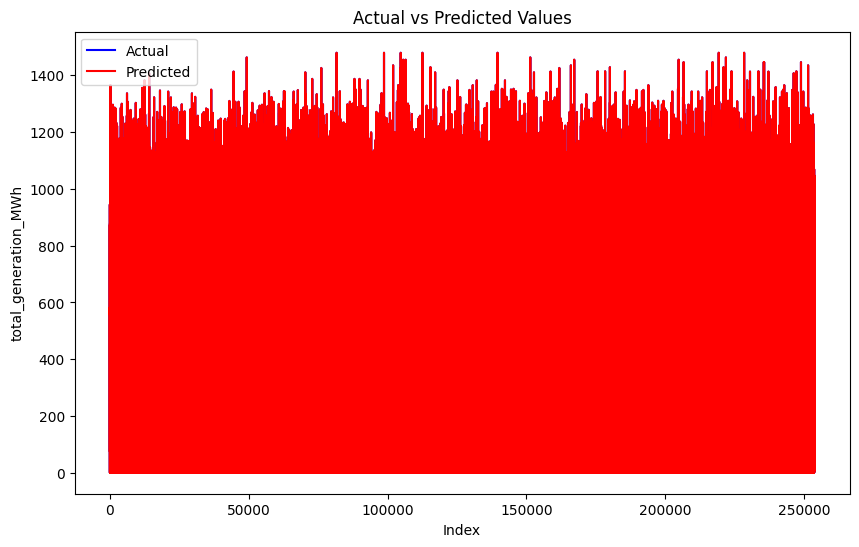

In [30]:
import matplotlib.pyplot as plt

# Plotten der tatsächlichen und vorhergesagten Werte
plt.figure(figsize=(10, 6))

# Tatsächliche Werte plotten
plt.plot(results_df['Actual'].values, label='Actual', color='blue')

# Vorhergesagte Werte plotten
plt.plot(results_df['Predicted'].values, label='Predicted', color='red')

# Titel und Beschriftungen hinzufügen
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('total_generation_MWh')

# Legende anzeigen
plt.legend()

# Plot anzeigen
plt.show()


In [24]:
# Speichern der trainierten Modelle in einer Datei
with open('trained_forecast_models.pkl', 'wb') as file:
    pickle.dump(forecast_models, file)

print("Die trainierten Modelle wurden in 'trained_forecast_models.pkl' gespeichert.")


Die trainierten Modelle wurden in 'trained_forecast_models.pkl' gespeichert.
